In [1]:
from transformers import Trainer, TrainingArguments
import torch
from torch import nn
from torch.utils.data import Dataset
import numpy as np
import math


/home/karl-saliba/anaconda3/envs/nuclear/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np

data = np.loadtxt("ENDF_B-VIII.1_AU-197(N,G)AU-198.yaml")  # (x, y)
print(data.shape)

(20330, 2)


In [3]:
x_raw = data[:, 0].astype(np.float32)
y_raw = data[:, 1].astype(np.float32)
x_log = np.log10(x_raw)
y_log = np.log10(y_raw)

In [4]:
from datasets import Dataset

full_ds = Dataset.from_dict({"x": x_log.tolist(), "y": y_log.tolist()})
ds = full_ds.train_test_split(test_size=0.1, seed=42)
train_ds, eval_ds = ds["train"], ds["test"]

In [5]:
# ---------- 4) Standardize using TRAIN stats ----------
x_mean, x_std = float(np.mean(train_ds["x"])), float(np.std(train_ds["x"]))
y_mean, y_std = float(np.mean(train_ds["y"])), float(np.std(train_ds["y"]))


def standardize(example):
    example["input"] = (example["x"] - x_mean) / x_std
    example["labels"] = (example["y"] - y_mean) / y_std
    del example["x"]
    del example["y"]
    return example


train_ds = train_ds.map(standardize)
eval_ds  = eval_ds.map(standardize)


Map: 100%|████████████████████████████████████████████████████| 2033/2033 [00:00<00:00, 5608.79 examples/s]


In [6]:
# import numpy as np
# import matplotlib.pyplot as plt

# x = np.random.lognormal(mean=1.0, sigma=0.5, size=1000)  # Skewed distribution
# x_std = (x - np.mean(x)) / np.std(x)

# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.hist(x, bins=50, alpha=0.7)
# plt.title("Original Distribution")

# plt.subplot(1,2,2)
# plt.hist(x_std, bins=50, alpha=0.7)
# plt.title("Standardized Distribution")

# plt.show()


In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_size=1,output_size=1):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Tanh(),nn.Linear(512, 512),
            nn.Tanh(),nn.Linear(512, 512),
            nn.Tanh(),nn.Linear(512, 512),
            nn.Tanh(),nn.Linear(512, 512),
            nn.Tanh(),nn.Linear(512, 512),
            nn.Tanh(),nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, output_size,bias=False),
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, input: torch.Tensor, labels: torch.Tensor = None):
        logits = self.linear_relu_stack(input)
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}
        
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): Tanh()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): Tanh()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): Tanh()
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): Tanh()
    (14): Linear(in_features=512, out_features=512, bias=True)
    (15): Tanh()
    (16): Linear(in_features=512, out_features=1, bias=False)
  )
  (loss_fn): MSELoss()
)


In [9]:
def compute_metrics(eval_pred):
    preds = eval_pred.predictions
    if isinstance(preds, tuple):
        preds = preds[0]
    preds = np.array(preds).reshape(-1)
    labels = eval_pred.label_ids.reshape(-1)

    mse  = float(np.mean((preds - labels) ** 2))
    rmse = float(math.sqrt(mse))
    mae  = float(np.mean(np.abs(preds - labels)))
    ss_res = float(np.sum((labels - preds) ** 2))
    
    ss_tot = float(np.sum((labels - np.mean(labels)) ** 2))
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}


def collate_scalar_to_column(batch):
    inputs = torch.tensor([ex["input"] for ex in batch], dtype=torch.float32).unsqueeze(-1)
    labels = torch.tensor([ex["labels"] for ex in batch], dtype=torch.float32).unsqueeze(-1)
    return {"input": inputs, "labels": labels}


In [10]:
training_args = TrainingArguments(
            output_dir='./results',
            learning_rate=1e-4,
            per_device_train_batch_size=4,  
            per_device_eval_batch_size=4,
            max_steps=10000,  # Replace with your desired number of steps
            weight_decay=0.02,
            eval_strategy='steps', 
            eval_steps=1000,  #the save step should be a multiple of eval step, savestep=500 by default
            lr_scheduler_type="cosine",
            warmup_ratio=0.1    

        )
# ---------------- 7) Trainer ----------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_scalar_to_column
)

In [11]:
trainer.train()

/home/karl-saliba/anaconda3/envs/nuclear/lib/python3.10/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Mse,Rmse,Mae,R2
1000,0.830500,0.739495,0.739495,0.859939,0.718739,0.246893
2000,0.812400,0.770998,0.770998,0.878065,0.724460,0.214811
3000,0.797300,0.756512,0.756512,0.869777,0.725071,0.229563
4000,0.826900,0.760098,0.760098,0.871836,0.720801,0.225911
5000,0.768400,0.735315,0.735315,0.857505,0.713381,0.251150
6000,0.780000,0.732545,0.732545,0.855888,0.708555,0.253971
7000,0.765900,0.722631,0.722631,0.850077,0.703600,0.264068
8000,0.746200,0.715406,0.715406,0.845817,0.706220,0.271425
9000,0.776800,0.707159,0.707159,0.840927,0.701801,0.279825
10000,0.743600,0.705525,0.705525,0.839955,0.701177,0.281489


/home/karl-saliba/anaconda3/envs/nuclear/lib/python3.10/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/karl-saliba/anaconda3/envs/nuclear/lib/python3.10/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/karl-saliba/anaconda3/envs/nuclear/lib/python3.10/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/karl-saliba/anaconda3/envs/nuclear/lib/python3.10/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(wa

TrainOutput(global_step=10000, training_loss=0.7932485870361328, metrics={'train_runtime': 209.8047, 'train_samples_per_second': 190.653, 'train_steps_per_second': 47.663, 'total_flos': 0.0, 'train_loss': 0.7932485870361328, 'epoch': 2.185792349726776})

In [28]:
torch.tensor(train_ds["input"]).reshape(-1,1).shape

torch.Size([18297, 1])

In [29]:
out=trainer.model(torch.tensor(train_ds["input"]).reshape(-1,1))

In [36]:
out_1=out["logits"].reshape(-1).detach().numpy()

In [38]:
np.array(train_ds["input"])

array([-0.89533457,  2.70737947, -0.19801255, ..., -0.34334403,
       -0.21795161,  0.1133052 ])

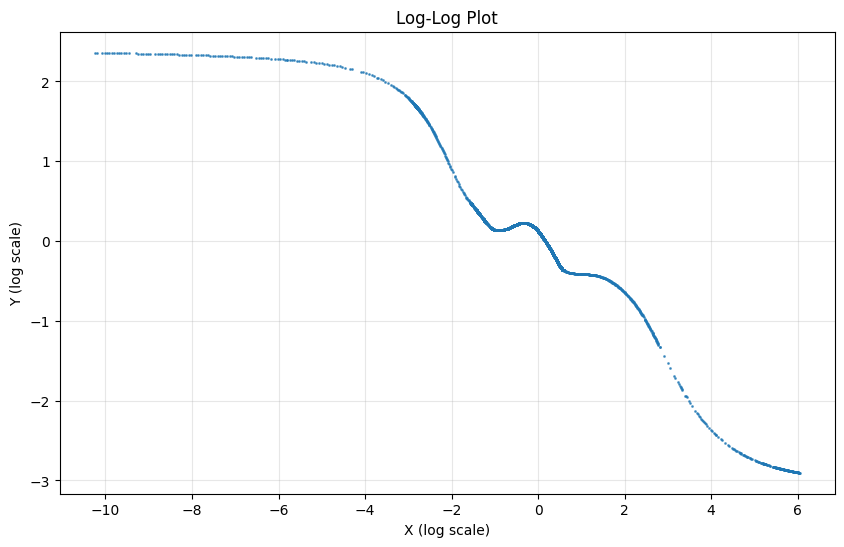

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Assuminx
x=np.array(train_ds["input"])
y = out_1# All rows, column 1

# Log-log plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', alpha=0.7, markersize=1)
plt.xlabel('X (log scale)')
plt.ylabel('Y (log scale)')
plt.title('Log-Log Plot')
plt.grid(True, alpha=0.3)
plt.show()